## 28. Pix2Pix with HANGUL JAMO

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as Data

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 28.1 Load Data

In [3]:
source_dir = "data/image_pair/source"
source_data = dsets.ImageFolder(source_dir, transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            ]))

In [4]:
target_dir = "data/image_pair/target"
target_data = dsets.ImageFolder(target_dir, transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            ]))

In [5]:
batch_size = 20

target_loader  = torch.utils.data.DataLoader(dataset=target_data,
                                           batch_size=batch_size,
                                           shuffle=False)

source_loader = torch.utils.data.DataLoader(dataset=source_data,
                                         batch_size=batch_size,
                                         shuffle=False)

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 20))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

## 28.2 Define Model

In [7]:
def downconvs(in_channels, out_channels, kernel_size, leakyrelu) :
    conv = [nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=0),
        nn.BatchNorm2d(out_channels)]

    if leakyrelu :
        conv.append(nn.LeakyReLU(0.2, inplace=True))

    else : 
        conv.append(nn.ReLU(inplace=True))

    return nn.Sequential(*conv)

def upconvs(in_channels, out_channels, kernel_size, leakyrelu) :
    conv = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=0),
        nn.Dropout2d(0.5),
        nn.BatchNorm2d(out_channels)]

    if leakyrelu :
        conv.append(nn.LeakyReLU(0.2, inplace=True))
    else : 
        conv.append(nn.ReLU(inplace=True))

    return nn.Sequential(*conv)

In [8]:
class Generator(nn.Module) :
    def __init__(self):
        super(Generator, self).__init__()
        
        self.c1 = downconvs(1, 16, 2, True)       
        self.c2 = downconvs(16, 32, 2, True)        
        self.c3 = downconvs(32, 64, 3, True)        
        self.c4 = downconvs(64, 128, 2, True)
        self.c5 = nn.Sequential(
            nn.Conv2d(128, 256, 2, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        
        self.uc1 = upconvs(256, 128, 2, False)
        self.uc2 = upconvs(256, 64, 2, False)
        self.uc3 = upconvs(128, 32, 3, False)
        self.uc4 = upconvs(64, 16, 2, False)
        
        self.uc5 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, 2, stride=2, padding=0),
            nn.Tanh()
        )
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.leakyrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x) :
        
        x1 = self.c1(x)
        x2 = self.c2(x1)
        x3 = self.c3(x2)
        x4 = self.c4(x3)
        x5 = self.c5(x4)
        
        out = torch.cat([x4,self.uc1(x5)], 1)
        out = torch.cat([x3,self.uc2(out)], 1)
        out = torch.cat([x2,self.uc3(out)], 1)
        out = torch.cat([x1,self.uc4(out)], 1)
        
        out = self.uc5(out)
        
        return out

In [9]:
G = Generator().cuda()

In [10]:
z = Variable(torch.randn((1, 1, 36, 36)))
G(z.cuda())

Variable containing:
(0 ,0 ,.,.) = 
 -0.0641  0.1502  0.0366  ...   0.1482 -0.0695 -0.1207
  0.1278 -0.0603  0.3023  ...   0.2010  0.1144  0.0396
  0.0467  0.0135  0.0302  ...   0.1013  0.0491 -0.1343
           ...             ⋱             ...          
  0.1702  0.2074 -0.0763  ...   0.1379  0.0907 -0.0014
 -0.0118  0.0132  0.0091  ...  -0.0041 -0.0231  0.1078
  0.2251  0.1996  0.0298  ...  -0.0727  0.1041  0.0151
[torch.cuda.FloatTensor of size 1x1x36x36 (GPU 0)]

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(2, 32, 2, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 2, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=2, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.main(x)
        out = out.view(-1, 1)
        
        return out

In [12]:
D = Discriminator().cuda()

In [13]:
z = Variable(torch.randn((1, 2, 36, 36)))
D(z.cuda())

Variable containing:
 0.5154
 0.5390
 0.4831
 0.4817
 0.5426
 0.4949
 0.5076
 0.5074
 0.5101
 0.5095
 0.5116
 0.5113
 0.5303
 0.5277
 0.5012
 0.5087
[torch.cuda.FloatTensor of size 16x1 (GPU 0)]

## 28.3 Train Model

In [14]:
l1_loss = nn.L1Loss()

In [15]:
def gan_loss(x, target_is_real):
    
    loss = nn.MSELoss()
    
    if target_is_real : 
        target_tensor = torch.FloatTensor([1.0]*batch_size*16)
    else :
        target_tensor = torch.FloatTensor([0.0]*batch_size*16)
        
    return loss(x, Variable(target_tensor).cuda())

In [16]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)

In [17]:
num_epoch = 50

Epoch [1/50], lter [10/36], D_Loss: 0.2440, G_Loss: 430.9938
Epoch [1/50], lter [20/36], D_Loss: 0.2324, G_Loss: 413.8320
Epoch [1/50], lter [30/36], D_Loss: 0.2176, G_Loss: 433.6822
Epoch [2/50], lter [10/36], D_Loss: 0.1991, G_Loss: 419.6423
Epoch [2/50], lter [20/36], D_Loss: 0.1873, G_Loss: 400.3479
Epoch [2/50], lter [30/36], D_Loss: 0.1637, G_Loss: 420.7248
Epoch [3/50], lter [10/36], D_Loss: 0.1349, G_Loss: 406.6880
Epoch [3/50], lter [20/36], D_Loss: 0.1207, G_Loss: 389.8694
Epoch [3/50], lter [30/36], D_Loss: 0.0901, G_Loss: 409.0227
Epoch [4/50], lter [10/36], D_Loss: 0.0671, G_Loss: 395.6642
Epoch [4/50], lter [20/36], D_Loss: 0.0588, G_Loss: 378.8501
Epoch [4/50], lter [30/36], D_Loss: 0.0367, G_Loss: 398.2439
Epoch [5/50], lter [10/36], D_Loss: 0.0286, G_Loss: 385.4962
Epoch [5/50], lter [20/36], D_Loss: 0.0287, G_Loss: 369.8072
Epoch [5/50], lter [30/36], D_Loss: 0.0164, G_Loss: 387.1898
Epoch [6/50], lter [10/36], D_Loss: 0.0150, G_Loss: 375.5383
Epoch [6/50], lter [20/3

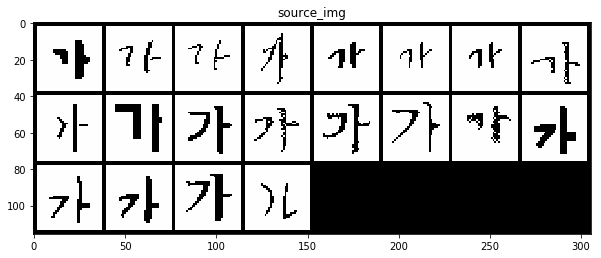

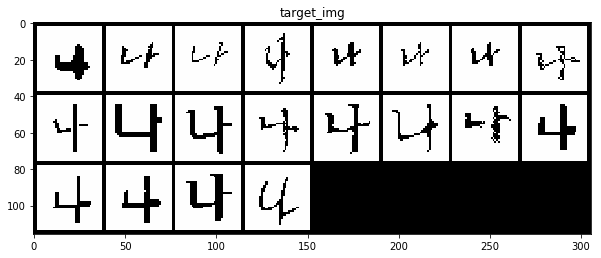

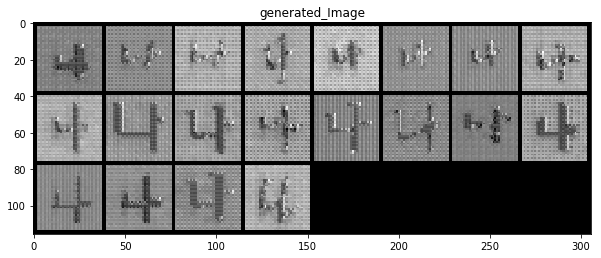

Epoch [11/50], lter [10/36], D_Loss: 0.0045, G_Loss: 319.3981
Epoch [11/50], lter [20/36], D_Loss: 0.0080, G_Loss: 304.2574
Epoch [11/50], lter [30/36], D_Loss: 0.0034, G_Loss: 322.0892
Epoch [12/50], lter [10/36], D_Loss: 0.0040, G_Loss: 309.6168
Epoch [12/50], lter [20/36], D_Loss: 0.0070, G_Loss: 293.3463
Epoch [12/50], lter [30/36], D_Loss: 0.0033, G_Loss: 310.9799
Epoch [13/50], lter [10/36], D_Loss: 0.0037, G_Loss: 297.1027
Epoch [13/50], lter [20/36], D_Loss: 0.0072, G_Loss: 282.3284
Epoch [13/50], lter [30/36], D_Loss: 0.0035, G_Loss: 296.7072
Epoch [14/50], lter [10/36], D_Loss: 0.0044, G_Loss: 285.4989
Epoch [14/50], lter [20/36], D_Loss: 0.0092, G_Loss: 269.6771
Epoch [14/50], lter [30/36], D_Loss: 0.0030, G_Loss: 286.9659
Epoch [15/50], lter [10/36], D_Loss: 0.0037, G_Loss: 274.6607
Epoch [15/50], lter [20/36], D_Loss: 0.0088, G_Loss: 259.0033
Epoch [15/50], lter [30/36], D_Loss: 0.0029, G_Loss: 272.2725
Epoch [16/50], lter [10/36], D_Loss: 0.0045, G_Loss: 261.4990
Epoch [1

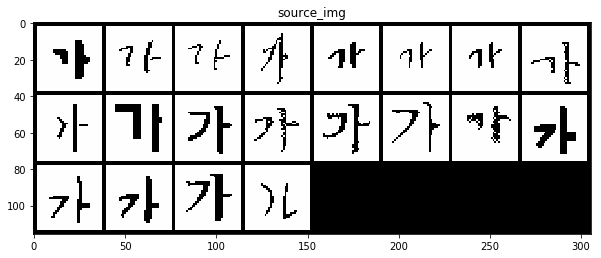

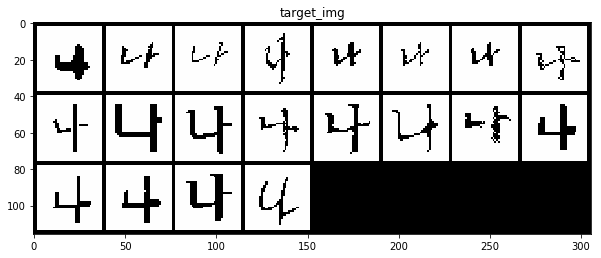

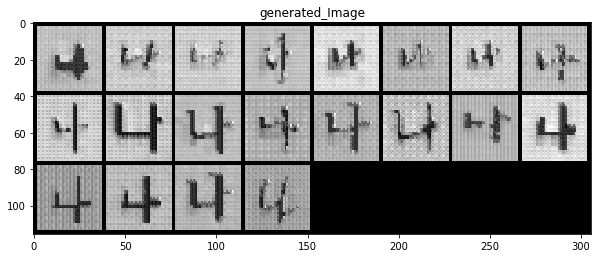

Epoch [21/50], lter [10/36], D_Loss: 0.0090, G_Loss: 206.9069
Epoch [21/50], lter [20/36], D_Loss: 0.0170, G_Loss: 193.5601
Epoch [21/50], lter [30/36], D_Loss: 0.0095, G_Loss: 203.8057
Epoch [22/50], lter [10/36], D_Loss: 0.0088, G_Loss: 192.7471
Epoch [22/50], lter [20/36], D_Loss: 0.0273, G_Loss: 181.7982
Epoch [22/50], lter [30/36], D_Loss: 0.0083, G_Loss: 191.8638
Epoch [23/50], lter [10/36], D_Loss: 0.0105, G_Loss: 188.5616
Epoch [23/50], lter [20/36], D_Loss: 0.0213, G_Loss: 174.4908
Epoch [23/50], lter [30/36], D_Loss: 0.0104, G_Loss: 183.5336
Epoch [24/50], lter [10/36], D_Loss: 0.0146, G_Loss: 172.8500
Epoch [24/50], lter [20/36], D_Loss: 0.0305, G_Loss: 165.2957
Epoch [24/50], lter [30/36], D_Loss: 0.0114, G_Loss: 174.8218
Epoch [25/50], lter [10/36], D_Loss: 0.0194, G_Loss: 167.0810
Epoch [25/50], lter [20/36], D_Loss: 0.0300, G_Loss: 158.6183
Epoch [25/50], lter [30/36], D_Loss: 0.0107, G_Loss: 164.2744
Epoch [26/50], lter [10/36], D_Loss: 0.0224, G_Loss: 158.6155
Epoch [2

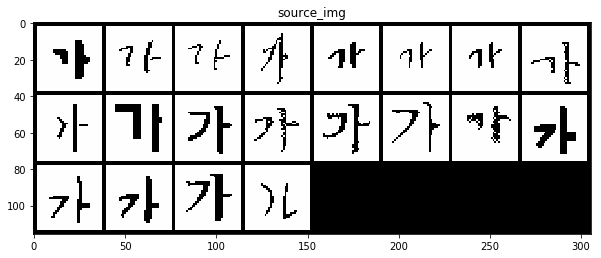

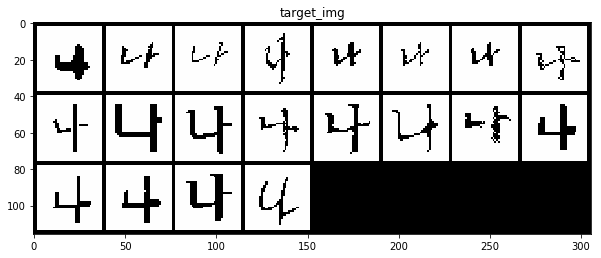

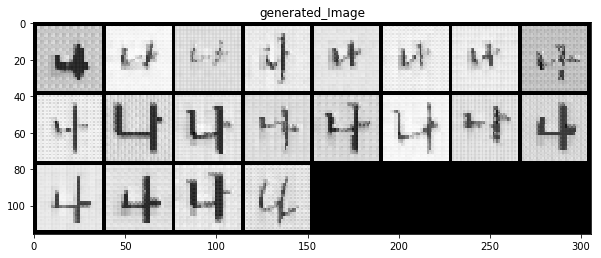

Epoch [31/50], lter [10/36], D_Loss: 0.0353, G_Loss: 129.7520
Epoch [31/50], lter [20/36], D_Loss: 0.0703, G_Loss: 119.9020
Epoch [31/50], lter [30/36], D_Loss: 0.0264, G_Loss: 122.1824
Epoch [32/50], lter [10/36], D_Loss: 0.0354, G_Loss: 119.2252
Epoch [32/50], lter [20/36], D_Loss: 0.0783, G_Loss: 121.3128
Epoch [32/50], lter [30/36], D_Loss: 0.0293, G_Loss: 118.9917
Epoch [33/50], lter [10/36], D_Loss: 0.0482, G_Loss: 117.6398
Epoch [33/50], lter [20/36], D_Loss: 0.0830, G_Loss: 110.2431
Epoch [33/50], lter [30/36], D_Loss: 0.0333, G_Loss: 116.0071
Epoch [34/50], lter [10/36], D_Loss: 0.0435, G_Loss: 112.2301
Epoch [34/50], lter [20/36], D_Loss: 0.0937, G_Loss: 106.0630
Epoch [34/50], lter [30/36], D_Loss: 0.0443, G_Loss: 107.6800
Epoch [35/50], lter [10/36], D_Loss: 0.0610, G_Loss: 103.8657
Epoch [35/50], lter [20/36], D_Loss: 0.0944, G_Loss: 102.0939
Epoch [35/50], lter [30/36], D_Loss: 0.0381, G_Loss: 103.0154
Epoch [36/50], lter [10/36], D_Loss: 0.0551, G_Loss: 101.3421
Epoch [3

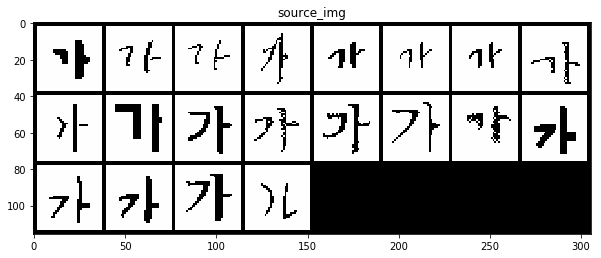

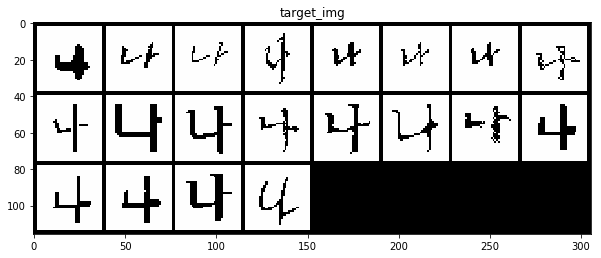

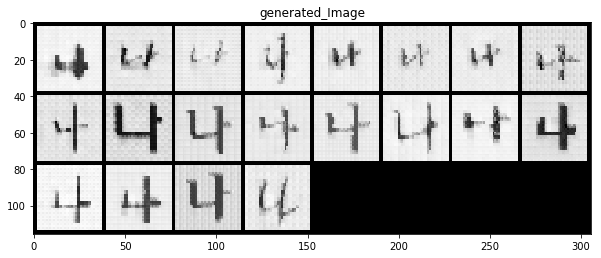

Epoch [41/50], lter [10/36], D_Loss: 0.0913, G_Loss: 85.6507
Epoch [41/50], lter [20/36], D_Loss: 0.1377, G_Loss: 82.2471
Epoch [41/50], lter [30/36], D_Loss: 0.0604, G_Loss: 83.6813
Epoch [42/50], lter [10/36], D_Loss: 0.0825, G_Loss: 81.0184
Epoch [42/50], lter [20/36], D_Loss: 0.1320, G_Loss: 81.5594
Epoch [42/50], lter [30/36], D_Loss: 0.0567, G_Loss: 81.6024
Epoch [43/50], lter [10/36], D_Loss: 0.0854, G_Loss: 82.2929
Epoch [43/50], lter [20/36], D_Loss: 0.1431, G_Loss: 77.1797
Epoch [43/50], lter [30/36], D_Loss: 0.0668, G_Loss: 77.9427
Epoch [44/50], lter [10/36], D_Loss: 0.1017, G_Loss: 76.6379
Epoch [44/50], lter [20/36], D_Loss: 0.1491, G_Loss: 78.0876
Epoch [44/50], lter [30/36], D_Loss: 0.0704, G_Loss: 75.7069
Epoch [45/50], lter [10/36], D_Loss: 0.0972, G_Loss: 74.1171
Epoch [45/50], lter [20/36], D_Loss: 0.1459, G_Loss: 74.2838
Epoch [45/50], lter [30/36], D_Loss: 0.0797, G_Loss: 74.8503
Epoch [46/50], lter [10/36], D_Loss: 0.1003, G_Loss: 72.5434
Epoch [46/50], lter [20/

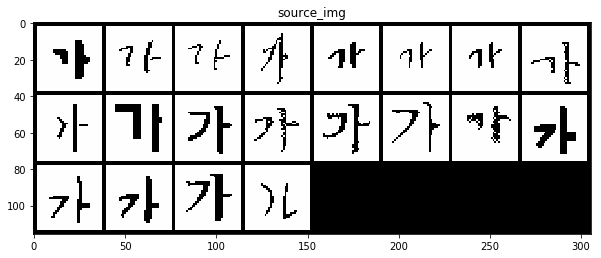

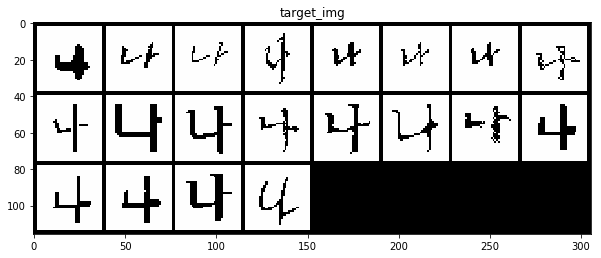

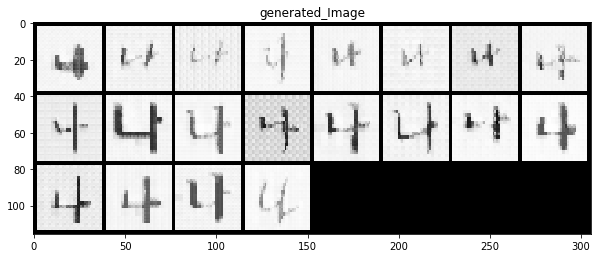

In [18]:
for epoch in range(num_epoch) :
    
    total_batch = len(target_data) // batch_size
    
    for i, (target_img, target_label) in enumerate(target_loader) : 
        for j, (source_img, source_label) in enumerate(source_loader) :

            if i != j : continue

            target_img = Variable(target_img).cuda()
            source_img = Variable(source_img).cuda()
            
            prob_real = D(torch.cat([target_img,source_img], 1))
            D_loss_real = gan_loss(prob_real, True)

            fake_img = G(source_img)
            prob_fake = D(torch.cat([fake_img,source_img], 1))
            D_loss_fake = gan_loss(prob_fake, False)

            D_loss = (D_loss_real + D_loss_fake) * 0.5

            D.zero_grad()
            D_loss.backward()
            D_optimizer.step()

            fake_img = G(source_img)
            prob_fake = D(torch.cat([fake_img,source_img], 1))
            G_loss_fake = gan_loss(prob_fake, True)
            G_loss_L1 = l1_loss(fake_img, target_img)

            G_loss = G_loss_fake + G_loss_L1 * 500

            G.zero_grad()
            G_loss.backward()
            G_optimizer.step()
    
        if (i+1) % 10 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epoch, i+1, total_batch, D_loss.data[0], G_loss.data[0]))
            
    if (epoch+1) % 10 == 0 :
        source_dataiter = iter(source_loader)

        images, labels = source_dataiter.next()
        imshow(torchvision.utils.make_grid(images, normalize=True), "source_img")

        target_dataiter = iter(target_loader)

        images, labels = target_dataiter.next()
        imshow(torchvision.utils.make_grid(images, normalize=True), "target_img")

        imshow(torchvision.utils.make_grid(G(Variable(images).cuda()).data.cpu().float(), normalize=True), "generated_Image")